## DrugCell Code in the Notebook

In [70]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.utils.data as du
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torch import optim
import numpy as np
import time
import sklearn
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import torch.utils.data as du
from torch.autograd import Variable
from time import time
import candle
import logging
from torchmetrics.functional import mean_absolute_error
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## INPUTS

In [71]:
model_name='DrugCell'
data_url="http://drugcell.ucsd.edu/downloads/data.tgz"
original_data="data.tgz"
data_predict='drugcell_test.txt'
data_model='drugcell_v1.pt'
predict_url = 'http://drugcell.ucsd.edu/downloads/drugcell_all.txt'
model_url = 'http://drugcell.ucsd.edu/downloads/drugcell_v1.pt'
CUDA_ID = 0
prebuilt_load = "Data/drugcell_v1.pt"
data_dir = "data/"
train_data_file = "data/drugcell_train.txt"
test_data_file = "data/drugcell_test.txt"
val_data_file = "data/drugcell_val.txt"
onto = "data/drugcell_ont.txt"
hidden='NOTEBOOK/MODEL/Hidden/'
result='NOTEBOOK/MODEL/Result/'
learning_rate = 1e-4
batch_size = 1000
eps=0.00001
genotype_hiddens = 6
drug_hiddens='100,50,6'
final_hiddens=6
genotype="data/cell2mutation.txt"
fingerprint='data/drug2fingerprint.txt'
cell2id='data/cell2ind.txt'
drug2id='data/drug2ind.txt'
gene2id='data/gene2ind.txt'
output_dir = "NOTEBOOK"
epochs=200
weight_decay=1e-5
#decay_rate = learning_rate / epochs
#optimizer = "adam"
loss = "mse"

## UTILS CODE

In [72]:
def pearson_corr(x, y):
    xx = x - torch.mean(x)
    yy = y - torch.mean(y)
    return torch.sum(xx*yy) / (torch.norm(xx, 2)*torch.norm(yy,2))

def calc_pcc(x, y):
    xx = x - torch.mean(x)
    yy = y - torch.mean(y)
    return torch.sum(xx*yy) / (torch.norm(xx, 2)*torch.norm(yy,2))


def calc_mae(y_true, y_pred):
    return sklearn.metrics.mean_absolute_error(y_true=y_true, y_pred=y_pred)

def calc_r2(y_true, y_pred):
    target_mean = torch.mean(y_pred)
    ss_tot = torch.sum((y_pred - target_mean) ** 2)
    ss_res = torch.sum((y_pred - y_true) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def load_ontology(file_name, gene2id_mapping):
    dG = nx.DiGraph()
    term_direct_gene_map = {}
    term_size_map = {}
    file_handle = open(file_name)
    gene_set = set()

    for line in file_handle:
        line = line.rstrip().split()
        if line[2] == 'default':
            dG.add_edge(line[0], line[1])
        else:
            if line[1] not in gene2id_mapping:
                continue

            if line[0] not in term_direct_gene_map:
                term_direct_gene_map[ line[0] ] = set()

            term_direct_gene_map[line[0]].add(gene2id_mapping[line[1]])
            gene_set.add(line[1])

    file_handle.close()
    
    print('There are', len(gene_set), 'genes')
    for term in dG.nodes():
        term_gene_set = set()
        if term in term_direct_gene_map:
            term_gene_set = term_direct_gene_map[term]

        deslist = nxadag.descendants(dG, term)

        for child in deslist:
            if child in term_direct_gene_map:
                term_gene_set = term_gene_set | term_direct_gene_map[child]

        # jisoo
        if len(term_gene_set) == 0:
            print('There is empty terms, please delete term:', term)
            sys.exit(1)
        else:
            term_size_map[term] = len(term_gene_set)

    leaves = [n for n in dG.nodes if dG.in_degree(n) == 0]
    #leaves = [n for n,d in dG.in_degree() if d==0]

    uG = dG.to_undirected()
    connected_subG_list = list(nxacc.connected_components(uG))

    print('There are', len(leaves), 'roots:', leaves[0])
    print('There are', len(dG.nodes()), 'terms')
    print('There are', len(connected_subG_list), 'connected componenets')

    if len(leaves) > 1:
        print('There are more than 1 root of ontology. Please use only one root.')
        sys.exit(1)
    if len(connected_subG_list) > 1:
        print( 'There are more than connected components. Please connect them.')
        sys.exit(1)

    return dG, leaves[0], term_size_map, term_direct_gene_map


def load_train_data(file_name, cell2id, drug2id):
    feature = []
    label = []
    feature_dict = {}
    with open(file_name, 'r') as fi:
        for line in fi:
            tokens = line.strip().split('\t')
            keys = list(cell2id.keys())[list(cell2id.values()).index(cell2id[tokens[0]])] + ";" + list(drug2id.keys())[list(drug2id.values()).index(drug2id[tokens[1]])]
            feature.append([cell2id[tokens[0]], drug2id[tokens[1]]])
            feature_dict[keys] = [cell2id[tokens[0]], drug2id[tokens[1]]]
            label.append([float(tokens[2])])
    return feature, label, feature_dict


def load_mapping(some_file):
    mapping = {}
    with  open(some_file) as fin:
        for line in fin:
            line = line.rstrip().split()
            mapping[line[1]] = int(line[0])
    return mapping

def check_file(some_file):
    if os.path.isfile(some_file):
        print(some_file)
    else:
        print('{0} file does not exist'.format(some_file))
        exit()
        
def prepare_predict_data(test_file, cell2id_mapping_file, drug2id_mapping_file):
    cell2id_mapping = load_mapping(cell2id_mapping_file)
    drug2id_mapping = load_mapping(drug2id_mapping_file)
    test_feature, test_label, feature_dict = load_train_data(test_file, cell2id_mapping, drug2id_mapping)
#    test_feature = test_feature_dict.values()
    torch_test_feature = torch.Tensor(test_feature)
    torch_test_label = torch.Tensor(test_label)
    print('Total number of cell lines = %d' % len(cell2id_mapping))
    print('Total number of drugs = %d' % len(drug2id_mapping))
    return torch_test_feature, torch_test_label, feature_dict

def prepare_train_data(train_file, test_file, cell2id_mapping_file, drug2id_mapping_file):

    # load mapping files
    cell2id_mapping = load_mapping(cell2id_mapping_file)
    drug2id_mapping = load_mapping(drug2id_mapping_file)
  
    train_feature, train_label, feature_dict  = load_train_data(train_file, cell2id_mapping, drug2id_mapping)
    test_feature, test_label, feature_dict  = load_train_data(test_file, cell2id_mapping, drug2id_mapping)

    print('Total number of cell lines = %d' % len(cell2id_mapping))
    print('Total number of drugs = %d' % len(drug2id_mapping))
    return (torch.Tensor(train_feature), 
            torch.FloatTensor(train_label), 
            torch.Tensor(test_feature), 
            torch.FloatTensor(test_label)), feature_dict, cell2id_mapping, drug2id_mapping

def build_input_vector(input_data, cell_features, drug_features):
    genedim = len(cell_features[0,:])
    drugdim = len(drug_features[0,:])
    feature = np.zeros((input_data.size()[0], (genedim+drugdim)))

    for i in range(input_data.size()[0]):
        feature[i] = np.concatenate((cell_features[int(input_data[i,0])], drug_features[int(input_data[i,1])]), axis=None)

    feature = torch.from_numpy(feature).float()
    return feature

def pearsonr(x, y):
    """Compute Pearson correlation.
    Args:
        x (torch.Tensor): 1D vector
        y (torch.Tensor): 1D vector of the same size as y.
    Raises:
        TypeError: not torch.Tensors.
        ValueError: not same shape or at least length 2.
    Returns:
        Pearson correlation coefficient.
    """
    if not isinstance(x, torch.Tensor) or not isinstance(y, torch.Tensor):
        raise TypeError('Function expects torch Tensors.')

    if len(x.shape) > 1 or len(y.shape) > 1:
        raise ValueError(' x and y must be 1D Tensors.')

    if len(x) != len(y):
        raise ValueError('x and y must have the same length.')

    if len(x) < 2:
        raise ValueError('x and y must have length at least 2.')

    # If an input is constant, the correlation coefficient is not defined.
    if bool((x == x[0]).all()) or bool((y == y[0]).all()):
        raise ValueError('Constant input, r is not defined.')

    mx = x - torch.mean(x)
    my = y - torch.mean(y)
    cost = (
        torch.sum(mx * my) /
        (torch.sqrt(torch.sum(mx**2)) * torch.sqrt(torch.sum(my**2)))
    )
    return torch.clamp(cost, min=-1.0, max=1.0)

def correlation_coefficient_loss(labels, predictions):
    """Compute loss based on Pearson correlation.
    Args:
        labels (torch.Tensor): reference values
        predictions (torch.Tensor): predicted values
    Returns:
        torch.Tensor: A loss that when minimized forces high squared correlation coefficient:
        \$1 - r(labels, predictions)^2\$  # noqa
    """
    return 1 - pearsonr(labels, predictions)**2


def mse_cc_loss(labels, predictions):
    """Compute loss based on MSE and Pearson correlation.
    The main assumption is that MSE lies in [0,1] range, i.e.: range is
    comparable with Pearson correlation-based loss.
    Args:
        labels (torch.Tensor): reference values
        predictions (torch.Tensor): predicted values
    Returns:
        torch.Tensor: A loss that computes the following:
        \$mse(labels, predictions) + 1 - r(labels, predictions)^2\$  # noqa
    """
    mse_loss_fn = nn.MSELoss()
    mse_loss = mse_loss_fn(predictions, labels)
    cc_loss = correlation_coefficient_loss(labels, predictions)
    return mse_loss + cc_loss

## DRUGCELL MODEL

In [73]:
class drugcell_nn(nn.Module):

    def __init__(self, term_size_map, term_direct_gene_map, dG, ngene, ndrug, root,
                 num_hiddens_genotype, num_hiddens_drug, num_hiddens_final):

        super(drugcell_nn, self).__init__()

        self.root = root
        self.num_hiddens_genotype = num_hiddens_genotype
        self.num_hiddens_drug = num_hiddens_drug

        # dictionary from terms to genes directly annotated with the term
        self.term_direct_gene_map = term_direct_gene_map

        # calculate the number of values in a state (term): term_size_map is the number of all genes annotated with the term
        self.cal_term_dim(term_size_map)

        # ngenes, gene_dim are the number of all genes
        self.gene_dim = ngene
        self.drug_dim = ndrug

        # add modules for neural networks to process genotypes
        self.contruct_direct_gene_layer()
        self.construct_NN_graph(dG)

        # add modules for neural networks to process drugs
        self.construct_NN_drug()

        # add modules for final layer
        final_input_size = num_hiddens_genotype + num_hiddens_drug[-1]
        self.add_module('final_linear_layer', nn.Linear(final_input_size, num_hiddens_final))
        self.add_module('final_batchnorm_layer', nn.BatchNorm1d(num_hiddens_final))
        self.add_module('final_aux_linear_layer', nn.Linear(num_hiddens_final,1))
        self.add_module('final_linear_layer_output', nn.Linear(1, 1))

    # calculate the number of values in a state (term)
    def cal_term_dim(self, term_size_map):

        self.term_dim_map = {}

        for term, term_size in term_size_map.items():
            num_output = self.num_hiddens_genotype

            # log the number of hidden variables per each term
            num_output = int(num_output)
#            print("term\t%s\tterm_size\t%d\tnum_hiddens\t%d" % (term, term_size, num_output))
            self.term_dim_map[term] = num_output


    # build a layer for forwarding gene that are directly annotated with the term
    def contruct_direct_gene_layer(self):

        for term, gene_set in self.term_direct_gene_map.items():
            if len(gene_set) == 0:
                print('There are no directed asscoiated genes for', term)
                sys.exit(1)

            # if there are some genes directly annotated with the term, add a layer taking in all genes and forwarding out only those genes
            self.add_module(term+'_direct_gene_layer', nn.Linear(self.gene_dim, len(gene_set)))


    # add modules for fully connected neural networks for drug processing
    def construct_NN_drug(self):
        input_size = self.drug_dim

        for i in range(len(self.num_hiddens_drug)):
            self.add_module('drug_linear_layer_' + str(i+1), nn.Linear(input_size, self.num_hiddens_drug[i]))
            self.add_module('drug_batchnorm_layer_' + str(i+1), nn.BatchNorm1d(self.num_hiddens_drug[i]))
            self.add_module('drug_aux_linear_layer1_' + str(i+1), nn.Linear(self.num_hiddens_drug[i],1))
            self.add_module('drug_aux_linear_layer2_' + str(i+1), nn.Linear(1,1))

            input_size = self.num_hiddens_drug[i]


    # start from bottom (leaves), and start building a neural network using the given ontology
    # adding modules --- the modules are not connected yet
    def construct_NN_graph(self, dG):

        self.term_layer_list = []   # term_layer_list stores the built neural network
        self.term_neighbor_map = {}

        # term_neighbor_map records all children of each term
        for term in dG.nodes():
            self.term_neighbor_map[term] = []
            for child in dG.neighbors(term):
                self.term_neighbor_map[term].append(child)

        while True:
            leaves = [n for n in dG.nodes() if dG.out_degree(n) == 0]
            #leaves = [n for n,d in dG.out_degree().items() if d==0]
            #leaves = [n for n,d in dG.out_degree() if d==0]

            if len(leaves) == 0:
                break

            self.term_layer_list.append(leaves)

            for term in leaves:

                # input size will be #chilren + #genes directly annotated by the term
                input_size = 0

                for child in self.term_neighbor_map[term]:
                    input_size += self.term_dim_map[child]

                if term in self.term_direct_gene_map:
                    input_size += len(self.term_direct_gene_map[term])

                # term_hidden is the number of the hidden variables in each state
                term_hidden = self.term_dim_map[term]

                self.add_module(term+'_linear_layer', nn.Linear(input_size, term_hidden))
                self.add_module(term+'_batchnorm_layer', nn.BatchNorm1d(term_hidden))
                self.add_module(term+'_aux_linear_layer1', nn.Linear(term_hidden,1))
                self.add_module(term+'_aux_linear_layer2', nn.Linear(1,1))

            dG.remove_nodes_from(leaves)


    # definition of forward function
    def forward(self, x):
        gene_input = x.narrow(1, 0, self.gene_dim)
        drug_input = x.narrow(1, self.gene_dim, self.drug_dim)

        # define forward function for genotype dcell #############################################
        term_gene_out_map = {}

        for term, _ in self.term_direct_gene_map.items():
            term_gene_out_map[term] = self._modules[term + '_direct_gene_layer'](gene_input)

        term_NN_out_map = {}
        aux_out_map = {}

        for i, layer in enumerate(self.term_layer_list):

            for term in layer:

                child_input_list = []

                for child in self.term_neighbor_map[term]:
                    child_input_list.append(term_NN_out_map[child])

                if term in self.term_direct_gene_map:
                    child_input_list.append(term_gene_out_map[term])

                child_input = torch.cat(child_input_list,1)

                term_NN_out = self._modules[term+'_linear_layer'](child_input)

                Tanh_out = torch.tanh(term_NN_out)
                term_NN_out_map[term] = self._modules[term+'_batchnorm_layer'](Tanh_out)
                aux_layer1_out = torch.tanh(self._modules[term+'_aux_linear_layer1'](term_NN_out_map[term]))
                aux_out_map[term] = self._modules[term+'_aux_linear_layer2'](aux_layer1_out)

        # define forward function for drug dcell #################################################
        drug_out = drug_input

        for i in range(1, len(self.num_hiddens_drug)+1, 1):
            drug_out = self._modules['drug_batchnorm_layer_'+str(i)]( torch.tanh(self._modules['drug_linear_layer_' + str(i)](drug_out)))
            term_NN_out_map['drug_'+str(i)] = drug_out

            aux_layer1_out = torch.tanh(self._modules['drug_aux_linear_layer1_'+str(i)](drug_out))
            aux_out_map['drug_'+str(i)] = self._modules['drug_aux_linear_layer2_'+str(i)](aux_layer1_out)

        # connect two neural networks at the top #################################################
        final_input = torch.cat((term_NN_out_map[self.root], drug_out), 1)

        out = self._modules['final_batchnorm_layer'](torch.tanh(self._modules['final_linear_layer'](final_input)))
        term_NN_out_map['final'] = out

        aux_layer_out = torch.tanh(self._modules['final_aux_linear_layer'](out))
        aux_out_map['final'] = self._modules['final_linear_layer_output'](aux_layer_out)

        return aux_out_map, term_NN_out_map
    

## TRAINING

In [74]:
def create_term_mask(term_direct_gene_map, gene_dim, cuda):
    term_mask_map = {}
    for term, gene_set in term_direct_gene_map.items():
        mask = torch.zeros(len(gene_set), gene_dim)
        for i, gene_id in enumerate(gene_set):
            mask[i, gene_id] = 1
            mask_gpu = torch.autograd.Variable(mask.cuda(cuda))
            term_mask_map[term] = mask_gpu
    return term_mask_map

In [75]:
def train_model(root, term_size_map, term_direct_gene_map, dG, train_data, 
                gene_dim, drug_dim, model_save_folder, train_epochs, batch_size, 
                learning_rate, num_hiddens_genotype, num_hiddens_drug, num_hiddens_final, 
                cell_features, drug_features):
    t = time()
    epoch_start_time = time()
    best_model = 0
    max_corr = 0
    logger = logging.getLogger(f'{model_name}')
    save_top_model = os.path.join(model_save_folder, 'results/drugcell_{}_{}.pt')
    model = drugcell_nn(term_size_map, term_direct_gene_map, dG, num_genes,
                        drug_dim, root, num_hiddens_genotype, num_hiddens_drug, num_hiddens_final)
    train_feature, train_label, test_feature, test_label = train_data

    device = torch.device("cuda")
    model.to(device)
    model.cuda(CUDA_ID)
    
    train_label_gpu = torch.autograd.Variable(train_label.cuda(CUDA_ID))
    test_label_gpu = torch.autograd.Variable(test_label.cuda(CUDA_ID))
    term_mask_map = create_term_mask(model.term_direct_gene_map, num_genes, CUDA_ID)

    # Define optimizer
    optimizer_dict = {"adam": "optim.adam"}
    #optim_value = optimizer
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           betas=(0.9, 0.99),
                           weight_decay=1e-5,
                           eps=eps)
    optimizer.zero_grad()
    scores = {}
    epoch_list = []
    train_loss_list = []
    train_corr_list = []
    train_scc_list = []
    test_loss_list = []
    test_corr_list = []
    test_scc_list = []
    for name, param in model.named_parameters():
        term_name = name.split('_')[0]
        if '_direct_gene_layer.weight' in name:
            param.data = torch.mul(param.data, term_mask_map[term_name]) * 0.1
        else:
            param.data = param.data * 0.1

    train_loader = du.DataLoader(du.TensorDataset(train_feature,train_label),
                                 batch_size=batch_size, shuffle=False)

    test_loader = du.DataLoader(du.TensorDataset(test_feature,test_label),
                                batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        epoch_list.append(epoch)
        train_predict =  torch.zeros(0,0).cuda(CUDA_ID)
        #logger.info(f"== Epoch [{epoch}/epochs}] ==")
        train_loss_mean = 0
        t = time()    
        for i, (inputdata, labels) in enumerate(train_loader):
            features = build_input_vector(inputdata, cell_features, drug_features)
            cuda_features = torch.autograd.Variable(features.cuda(CUDA_ID))
            cuda_labels = torch.autograd.Variable(labels.cuda(CUDA_ID))

            optimizer.zero_grad()
            aux_out_map, _ = model(cuda_features)

            if train_predict.size()[0] == 0:
                train_predict = aux_out_map['final'].data
            else:
                train_predict = torch.cat([train_predict, aux_out_map['final'].data], dim=0)

            train_loss = 0
            count = 0
            for name, output in aux_out_map.items():
                count +=1
                loss = nn.MSELoss()
                if name == 'final':
                    train_loss += loss(output, cuda_labels)
                else:
                    train_loss += 0.2 * loss(output, cuda_labels)
            train_loss.backward()
#            train_loss_mean = train_loss/count
            train_loss_mean = train_loss
            for name, param in model.named_parameters():
                if '_direct_gene_layer.weight' not in name:
                    continue
                term_name = name.split('_')[0]
                param.grad.data = torch.mul(param.grad.data, term_mask_map[term_name])

            optimizer.step()
        #epoch_train_test_df['train_loss'] = train_loss_mean.cpu().detach().numpy()/len(train_loader)
        train_loss_list.append(train_loss_mean.cpu().detach().numpy()/len(train_loader))
        logger.info(
            "\t **** TRAINING ****   "
            f"Epoch [{epoch + 1}/{epochs}], "
            f"loss: {train_loss_mean / len(train_loader):.5f}. "
            f"This took {time() - t:.1f} secs."
        )

        train_corr = pearson_corr(train_predict, train_label_gpu)
        train_corr_list.append(train_corr.cpu().detach().numpy())
        torch.save(model, model_save_folder + '/model_' + str(epoch) + '.pt')
        train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
        train_predictions = train_predictions[0:len(train_predictions)]
        train_labels = np.array([l.cpu() for label in train_label_gpu for l in label],dtype = np.float)
        train_scc = spearmanr(train_labels, train_predictions)[0]
        train_scc_list.append(train_scc)
        model.eval()

        test_predict = torch.zeros(0,0).cuda(CUDA_ID)

        test_loss = 0
        tissue = []
        drug = []
        for i, (inputdata, labels) in enumerate(test_loader):
            features = build_input_vector(inputdata, cell_features, drug_features)
            cuda_features = Variable(features.cuda(CUDA_ID))
            aux_out_map, _ = model(cuda_features)
            values = inputdata.cpu().detach().numpy().tolist()
            keys = [i for i in feature_dict for x in values if feature_dict [i]== x ]
            tissue = [i.split(';')[0] for i in keys]
            drug = [i.split(';')[1] for i in keys]
            loss = nn.MSELoss()
            if test_predict.size()[0] == 0:
                test_predict = aux_out_map['final'].data
                loss_a =  loss(test_predict, cuda_labels)
                test_loss += loss_a.item() 
            else:
                test_predict = torch.cat([test_predict, aux_out_map['final'].data], dim=0)
                loss_a =  loss(test_predict, cuda_labels)
                test_loss += loss_a.item()
        logger.info(
            "\t **** TEST ****   "
            f"Epoch [{epoch + 1}/{epochs}], "
            f"loss: {test_loss / len(test_loader):.5f}. "
            f"This took {time() - t:.1f} secs."
        )
        predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
        predictions = predictions[0:len(predictions)]
        labels = np.array([l.cpu() for label in labels for l in label],dtype = np.float)
        labels = labels[0:len(labels)]
        test_pearson_a = calc_pcc(torch.Tensor(predictions), torch.Tensor(labels))
        test_spearman_a = spearmanr(labels, predictions)[0]
        test_mean_absolute_error = sklearn.metrics.mean_absolute_error(y_true=labels, y_pred=predictions)
        test_r2 = sklearn.metrics.r2_score(y_true=labels, y_pred=predictions)
        test_rmse_a = np.sqrt(np.mean((predictions - labels)**2))
        test_loss_a = test_loss / len(test_loader)
        epoch_end_time = time()
        test_loss_a = test_loss/len(test_loader)
#        test_loss_a = test_loss.cpu().detach().numpy()/len(test_loader)
        test_loss_list.append(test_loss_a)
        test_corr_list.append(test_pearson_a.cpu().detach().numpy())
        test_scc_list.append(test_spearman_a)
        if epoch == 0:
            min_test_loss = test_loss_a
            scores['test_loss'] = min_test_loss
            scores['test_pcc'] = test_pearson_a.cpu().detach().numpy().tolist()
            scores['test_MSE'] = test_mean_absolute_error
            scores['test_r2'] = test_r2
            scores['test_scc'] = test_spearman_a
        if test_loss_a < min_test_loss:
            min_test_loss = test_loss_a
            scores['test_loss'] = min_test_loss
            scores['test_pcc'] = test_pearson_a.cpu().detach().numpy().tolist()
            scores['test_MSE'] = test_mean_absolute_error
            scores['test_r2'] = test_r2
            scores['test_scc'] = test_spearman_a

        if test_pearson_a >= max_corr:
            max_corr = test_pearson_a
            best_model = epoch
            pred = pd.DataFrame({"Tissue": tissue, "Drug": drug, "True": labels, "Pred": predictions}).reset_index()
            pred_fname = str(model_save_folder+'/results/test_pred.csv')
            pred.to_csv(pred_fname, index=False)
#        print("epoch\t%d\tcuda_id\t%d\ttrain_corr\t%.6f\tval_corr\t%.6f\ttrain_loss\t%.6f\telapsed_time\t%s" % (epoch,
#                                                                                                                CUDA_ID,
#                                                                                                                train_corr, test_corr,
#                                                                                                                train_loss, epoch_end_time-epoch_start_time))
        epoch_start_time = epoch_end_time
        #ckpt.ckpt_epoch(epoch, test_loss_a)
    torch.save(model, model_save_folder + '/model_final.pt')    
    print("Best performed model (epoch)\t%d" % best_model)
#    torch.save(save_top_model.format('epoch', '0', best_model))
    cols = ['epoch', 'train_loss', 'train_corr', 'train_scc', 'test_loss', 'test_corr', 'test_scc']
    epoch_train_test_df = pd.DataFrame(columns=cols, index=range(epochs))
    epoch_train_test_df['epoch'] = epoch_list
    epoch_train_test_df['train_loss'] = train_loss_list
    epoch_train_test_df['train_corr'] = train_corr_list
    epoch_train_test_df['train_scc'] = train_scc_list    
    epoch_train_test_df['test_loss'] = test_loss_list
    epoch_train_test_df['test_corr'] = test_corr_list
    epoch_train_test_df['test_scc'] = test_scc_list
    loss_results_name = str(model_save_folder+'/results/train_val_loss_results.csv')
    epoch_train_test_df.to_csv(loss_results_name, index=False)
    print(scores)
    return scores

## INFERENCE

In [76]:
def predict_dcell(predict_data, gene_dim, drug_dim, model_file, hidden_folder,
                  batch_size, result_file, cell_features, drug_features, CUDA_ID,output_dir):
    feature_dim = gene_dim + drug_dim
    device = torch.device("cuda")
    model = torch.load(model_file, map_location='cuda:%d' % CUDA_ID)
    #checkpoint = torch.load(trained_model, map_location='cuda:%d' % CUDA_ID)
    model.to(device)
    predict_feature, predict_label, feature_dict = predict_data

    predict_label_gpu = predict_label.cuda(CUDA_ID)
    model.cuda(CUDA_ID)
    model.eval()

    test_loader = du.DataLoader(du.TensorDataset(predict_feature,predict_label), 
                                batch_size=batch_size, shuffle=False)
    model_dir = output_dir

    #Test
    test_predict = torch.zeros(0,0).cuda(CUDA_ID)
    term_hidden_map = {}
    test_loss = 0
    batch_num = 0
    test_loss_list = []
    test_corr_list = []
    drug_list = []
    tissue_list = []
    print("Begin test evaluation")
    for i, (inputdata, labels) in enumerate(test_loader):
        # Convert torch tensor to Variable
        cuda_labels = torch.autograd.Variable(labels.cuda(CUDA_ID))
        features = build_input_vector(inputdata, cell_features, drug_features)
        cuda_features = Variable(features.cuda(CUDA_ID), requires_grad=False)
        loss = nn.MSELoss()
        values = inputdata.cpu().detach().numpy().tolist()
        keys = [i for i in feature_dict for x in values if feature_dict [i]== x ]
        tissue = [i.split(';')[0] for i in keys]
        tissue_list.append(tissue)
        drug = [i.split(';')[1] for i in keys]
        drug_list.append(drug)
        # make prediction for test data
        aux_out_map, term_hidden_map = model(cuda_features)
        if test_predict.size()[0] == 0:
            test_predict = aux_out_map['final'].data
            loss_a =  loss(test_predict, cuda_labels)
            print(loss_a)
            test_loss += loss_a.item()
        else:
            test_predict = torch.cat([test_predict, aux_out_map['final'].data], dim=0)
            loss_a =  loss(test_predict, cuda_labels)
            print(loss_a)
            test_loss += loss_a.item()

        batch_num += 1
    predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
    predictions = predictions[0:len(predictions)]
    labels = np.array([l.cpu() for label in labels for l in label],dtype = np.float)
    labels = labels[0:len(labels)]
    test_pearson_a = pearson_corr(torch.Tensor(predictions), torch.Tensor(labels))
    test_spearman_a = spearmanr(labels, predictions)[0]
    test_mean_absolute_error = sklearn.metrics.mean_absolute_error(y_true=labels, y_pred=predictions)
    test_r2 = sklearn.metrics.r2_score(y_true=labels, y_pred=predictions)
    test_rmse_a = np.sqrt(np.mean((predictions - labels)**2))
    test_loss_a = test_loss / len(test_loader)
    epoch_end_time = time()
    test_loss_a = test_loss/len(test_loader)
    test_loss_list.append(test_loss_a)
    test_corr_list.append(test_pearson_a.cpu().detach().numpy())
    min_test_loss = test_loss_a
    scores = {}
    scores['test_loss'] = min_test_loss
    scores['test_pcc'] = test_pearson_a.cpu().detach().numpy().tolist()
    scores['test_MSE'] = test_mean_absolute_error
    scores['test_r2'] = test_r2
    scores['test_scc'] = test_spearman_a
    test_corr = pearson_corr(test_predict, predict_label_gpu)
    print("Test pearson corr\t%s\t%.6f" % (model.root, test_corr))
    print("Test spearman corr\t%s\t%.6f" % (model.root, test_spearman_a))
    print(scores)
    cols = ['drug', 'tissue', 'test_loss', 'test_corr', 'test_scc']
    metrics_test_df = pd.DataFrame(columns=cols, index=range(len(test_loader)))
    metrics_test_df['test_loss'] = test_loss_list
    metrics_test_df['test_corr'] = test_corr_list
    loss_results_name = str(model_dir+'/results/test_metrics_results.csv')
    metrics_test_df.to_csv(loss_results_name, index=False)
    np.savetxt(result_file+'/drugcell.predict', test_predict.cpu().numpy(),'%.4e')

## RUN TRAIN

In [77]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#print(train_data_file)
train_data, feature_dict, cell2id_mapping, drug2id_mapping = prepare_train_data(train_data_file, 
                                                                  test_data_file, cell2id, drug2id)
gene2id_mapping = load_mapping(gene2id)
modeldir = output_dir
cell_features = np.genfromtxt(genotype, delimiter=',')
drug_features = np.genfromtxt(fingerprint, delimiter=',')

num_cells = len(cell2id_mapping)
num_drugs = len(drug2id_mapping)
num_genes = len(gene2id_mapping)
drug_dim = len(drug_features[0,:])

# load ontology
dG, root, term_size_map, term_direct_gene_map = load_ontology(onto, gene2id_mapping)

# load the number of hiddens #######
num_hiddens_genotype = genotype_hiddens

num_hiddens_drug = list(map(int, drug_hiddens.split(',')))

num_hiddens_final = final_hiddens
#####################################

CUDA_ID = CUDA_ID

train_model(root, term_size_map, term_direct_gene_map, dG, 
            train_data, num_genes, drug_dim, modeldir, epochs,
            batch_size, learning_rate, num_hiddens_genotype, num_hiddens_drug, 
            num_hiddens_final, cell_features, drug_features)


Total number of cell lines = 1225
Total number of drugs = 684
There are 3008 genes
There are 1 roots: GO:0008150
There are 2086 terms
There are 1 connected componenets
INFO:DrugCell:	 **** TRAINING ****   Epoch [1/200], loss: 31.27279. This took 48.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [1/200], loss: 0.69532. This took 56.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [2/200], loss: 31.19688. This took 46.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [2/200], loss: 0.69351. This took 53.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [3/200], loss: 31.12101. This took 44.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [3/200], loss: 0.69169. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [4/200], loss: 31.04523. This took 46.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [4/200], loss: 0.68986. This took 53.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [5/200], loss: 30.96943. This took 51.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [5/200], loss: 0.68804. This took 60.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [6/200], loss: 30.89362. This took 54.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [6/200], loss: 0.68620. This took 61.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [7/200], loss: 30.81780. This took 45.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [7/200], loss: 0.68436. This took 52.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [8/200], loss: 30.74195. This took 46.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [8/200], loss: 0.68255. This took 54.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [9/200], loss: 30.66609. This took 48.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [9/200], loss: 0.68079. This took 56.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [10/200], loss: 30.59006. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [10/200], loss: 0.67907. This took 56.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [11/200], loss: 30.51408. This took 50.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [11/200], loss: 0.67731. This took 59.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [12/200], loss: 30.43791. This took 47.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [12/200], loss: 0.67547. This took 56.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [13/200], loss: 30.36168. This took 45.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [13/200], loss: 0.67359. This took 52.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [14/200], loss: 30.28531. This took 45.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [14/200], loss: 0.67166. This took 52.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [15/200], loss: 30.20882. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [15/200], loss: 0.66969. This took 57.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [16/200], loss: 30.13216. This took 45.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [16/200], loss: 0.66767. This took 53.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [17/200], loss: 30.05538. This took 51.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [17/200], loss: 0.66558. This took 59.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [18/200], loss: 29.97847. This took 49.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [18/200], loss: 0.66343. This took 57.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [19/200], loss: 29.90134. This took 54.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [19/200], loss: 0.66118. This took 62.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [20/200], loss: 29.82402. This took 53.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [20/200], loss: 0.65883. This took 61.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [21/200], loss: 29.74658. This took 50.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [21/200], loss: 0.65636. This took 58.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [22/200], loss: 29.66894. This took 51.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [22/200], loss: 0.65375. This took 57.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [23/200], loss: 29.59104. This took 45.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [23/200], loss: 0.65101. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [24/200], loss: 29.51303. This took 41.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [24/200], loss: 0.64818. This took 47.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [25/200], loss: 29.43476. This took 36.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [25/200], loss: 0.64534. This took 41.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [26/200], loss: 29.35621. This took 48.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [26/200], loss: 0.64258. This took 55.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [27/200], loss: 29.27748. This took 53.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [27/200], loss: 0.64001. This took 59.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [28/200], loss: 29.19854. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [28/200], loss: 0.63757. This took 56.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [29/200], loss: 29.11931. This took 48.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [29/200], loss: 0.63518. This took 56.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [30/200], loss: 29.03988. This took 46.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [30/200], loss: 0.63250. This took 54.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [31/200], loss: 28.96020. This took 47.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [31/200], loss: 0.62937. This took 55.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [32/200], loss: 28.88024. This took 44.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [32/200], loss: 0.62622. This took 51.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [33/200], loss: 28.80002. This took 50.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [33/200], loss: 0.62367. This took 57.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [34/200], loss: 28.71958. This took 55.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [34/200], loss: 0.62132. This took 62.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [35/200], loss: 28.63877. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [35/200], loss: 0.61878. This took 56.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [36/200], loss: 28.55771. This took 51.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [36/200], loss: 0.61622. This took 58.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [37/200], loss: 28.47644. This took 51.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [37/200], loss: 0.61373. This took 57.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [38/200], loss: 28.39485. This took 53.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [38/200], loss: 0.61148. This took 60.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [39/200], loss: 28.31299. This took 48.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [39/200], loss: 0.60936. This took 54.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [40/200], loss: 28.23085. This took 48.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [40/200], loss: 0.60721. This took 56.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [41/200], loss: 28.14848. This took 48.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [41/200], loss: 0.60500. This took 56.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [42/200], loss: 28.06576. This took 46.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [42/200], loss: 0.60286. This took 53.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [43/200], loss: 27.98281. This took 57.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [43/200], loss: 0.60080. This took 64.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [44/200], loss: 27.89952. This took 43.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [44/200], loss: 0.59880. This took 50.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [45/200], loss: 27.81602. This took 51.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [45/200], loss: 0.59697. This took 57.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [46/200], loss: 27.73222. This took 49.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [46/200], loss: 0.59537. This took 56.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [47/200], loss: 27.64816. This took 49.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [47/200], loss: 0.59386. This took 56.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [48/200], loss: 27.56384. This took 50.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [48/200], loss: 0.59239. This took 57.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [49/200], loss: 27.47925. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [49/200], loss: 0.59114. This took 62.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [50/200], loss: 27.39433. This took 47.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [50/200], loss: 0.59001. This took 54.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [51/200], loss: 27.30922. This took 50.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [51/200], loss: 0.58871. This took 58.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [52/200], loss: 27.22383. This took 45.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [52/200], loss: 0.58739. This took 52.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [53/200], loss: 27.13816. This took 59.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [53/200], loss: 0.58597. This took 66.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [54/200], loss: 27.05223. This took 54.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [54/200], loss: 0.58463. This took 60.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [55/200], loss: 26.96608. This took 54.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [55/200], loss: 0.58348. This took 60.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [56/200], loss: 26.87965. This took 45.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [56/200], loss: 0.58246. This took 53.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [57/200], loss: 26.79299. This took 46.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [57/200], loss: 0.58171. This took 53.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [58/200], loss: 26.70602. This took 45.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [58/200], loss: 0.58092. This took 52.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [59/200], loss: 26.61885. This took 58.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [59/200], loss: 0.57982. This took 66.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [60/200], loss: 26.53142. This took 45.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [60/200], loss: 0.57832. This took 52.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [61/200], loss: 26.44374. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [61/200], loss: 0.57658. This took 57.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [62/200], loss: 26.35586. This took 48.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [62/200], loss: 0.57470. This took 56.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [63/200], loss: 26.26771. This took 50.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [63/200], loss: 0.57285. This took 58.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [64/200], loss: 26.17931. This took 50.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [64/200], loss: 0.57117. This took 57.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [65/200], loss: 26.09065. This took 45.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [65/200], loss: 0.56970. This took 51.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [66/200], loss: 26.00176. This took 43.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [66/200], loss: 0.56850. This took 49.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [67/200], loss: 25.91266. This took 52.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [67/200], loss: 0.56742. This took 59.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [68/200], loss: 25.82329. This took 46.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [68/200], loss: 0.56625. This took 52.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [69/200], loss: 25.73371. This took 55.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [69/200], loss: 0.56498. This took 62.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [70/200], loss: 25.64389. This took 47.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [70/200], loss: 0.56368. This took 54.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [71/200], loss: 25.55385. This took 46.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [71/200], loss: 0.56202. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [72/200], loss: 25.46361. This took 51.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [72/200], loss: 0.56061. This took 58.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [73/200], loss: 25.37309. This took 49.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [73/200], loss: 0.55865. This took 56.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [74/200], loss: 25.28238. This took 48.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [74/200], loss: 0.55700. This took 55.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [75/200], loss: 25.19145. This took 53.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [75/200], loss: 0.55539. This took 60.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [76/200], loss: 25.10023. This took 49.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [76/200], loss: 0.55366. This took 55.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [77/200], loss: 25.00886. This took 49.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [77/200], loss: 0.55193. This took 55.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [78/200], loss: 24.91727. This took 44.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [78/200], loss: 0.55035. This took 51.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [79/200], loss: 24.82543. This took 53.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [79/200], loss: 0.54881. This took 59.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [80/200], loss: 24.73337. This took 48.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [80/200], loss: 0.54718. This took 55.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [81/200], loss: 24.64114. This took 47.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [81/200], loss: 0.54554. This took 55.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [82/200], loss: 24.54865. This took 45.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [82/200], loss: 0.54409. This took 51.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [83/200], loss: 24.45596. This took 50.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [83/200], loss: 0.54292. This took 58.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [84/200], loss: 24.36306. This took 51.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [84/200], loss: 0.54137. This took 58.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [85/200], loss: 24.26995. This took 47.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [85/200], loss: 0.53961. This took 53.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [86/200], loss: 24.17664. This took 57.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [86/200], loss: 0.53847. This took 64.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [87/200], loss: 24.08311. This took 51.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [87/200], loss: 0.53746. This took 57.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [88/200], loss: 23.98938. This took 46.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [88/200], loss: 0.53545. This took 54.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [89/200], loss: 23.89548. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [89/200], loss: 0.53351. This took 62.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [90/200], loss: 23.80134. This took 47.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [90/200], loss: 0.53299. This took 54.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [91/200], loss: 23.70700. This took 43.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [91/200], loss: 0.53129. This took 48.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [92/200], loss: 23.61248. This took 41.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [92/200], loss: 0.52810. This took 48.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [93/200], loss: 23.51777. This took 38.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [93/200], loss: 0.52755. This took 44.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [94/200], loss: 23.42284. This took 49.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [94/200], loss: 0.52709. This took 56.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [95/200], loss: 23.32774. This took 46.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [95/200], loss: 0.52263. This took 53.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [96/200], loss: 23.23246. This took 51.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [96/200], loss: 0.52129. This took 58.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [97/200], loss: 23.13698. This took 49.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [97/200], loss: 0.52141. This took 56.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [98/200], loss: 23.04131. This took 50.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [98/200], loss: 0.51552. This took 56.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [99/200], loss: 22.94546. This took 55.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [99/200], loss: 0.51424. This took 63.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [100/200], loss: 22.84943. This took 53.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [100/200], loss: 0.51352. This took 59.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [101/200], loss: 22.75324. This took 58.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [101/200], loss: 0.50764. This took 68.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [102/200], loss: 22.65689. This took 50.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [102/200], loss: 0.50759. This took 56.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [103/200], loss: 22.56031. This took 47.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [103/200], loss: 0.50570. This took 55.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [104/200], loss: 22.46359. This took 55.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [104/200], loss: 0.50088. This took 62.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [105/200], loss: 22.36669. This took 51.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [105/200], loss: 0.50331. This took 58.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [106/200], loss: 22.26963. This took 48.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [106/200], loss: 0.49809. This took 55.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [107/200], loss: 22.17239. This took 55.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [107/200], loss: 0.49819. This took 62.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [108/200], loss: 22.07499. This took 43.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [108/200], loss: 0.49772. This took 49.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [109/200], loss: 21.97746. This took 58.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [109/200], loss: 0.49253. This took 65.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [110/200], loss: 21.87978. This took 43.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [110/200], loss: 0.49513. This took 50.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [111/200], loss: 21.78190. This took 47.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [111/200], loss: 0.48607. This took 54.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [112/200], loss: 21.68391. This took 43.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [112/200], loss: 0.48812. This took 50.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [113/200], loss: 21.58575. This took 51.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [113/200], loss: 0.48041. This took 58.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [114/200], loss: 21.48745. This took 48.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [114/200], loss: 0.47850. This took 54.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [115/200], loss: 21.38904. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [115/200], loss: 0.47403. This took 55.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [116/200], loss: 21.29045. This took 49.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [116/200], loss: 0.47263. This took 57.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [117/200], loss: 21.19172. This took 50.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [117/200], loss: 0.46572. This took 58.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [118/200], loss: 21.09286. This took 47.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [118/200], loss: 0.46501. This took 53.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [119/200], loss: 20.99391. This took 51.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [119/200], loss: 0.45976. This took 58.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [120/200], loss: 20.89480. This took 51.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [120/200], loss: 0.45801. This took 57.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [121/200], loss: 20.79558. This took 46.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [121/200], loss: 0.45154. This took 53.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [122/200], loss: 20.69621. This took 43.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [122/200], loss: 0.45264. This took 50.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [123/200], loss: 20.59676. This took 51.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [123/200], loss: 0.44133. This took 58.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [124/200], loss: 20.49720. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [124/200], loss: 0.44515. This took 57.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [125/200], loss: 20.39748. This took 52.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [125/200], loss: 0.43134. This took 59.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [126/200], loss: 20.29771. This took 52.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [126/200], loss: 0.43607. This took 60.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [127/200], loss: 20.19779. This took 46.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [127/200], loss: 0.42637. This took 55.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [128/200], loss: 20.09781. This took 45.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [128/200], loss: 0.42670. This took 52.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [129/200], loss: 19.99772. This took 52.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [129/200], loss: 0.42189. This took 59.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [130/200], loss: 19.89754. This took 48.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [130/200], loss: 0.41584. This took 55.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [131/200], loss: 19.79724. This took 46.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [131/200], loss: 0.41342. This took 53.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [132/200], loss: 19.69688. This took 47.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [132/200], loss: 0.40885. This took 54.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [133/200], loss: 19.59643. This took 54.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [133/200], loss: 0.40423. This took 61.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [134/200], loss: 19.49592. This took 46.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [134/200], loss: 0.39708. This took 52.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [135/200], loss: 19.39537. This took 43.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [135/200], loss: 0.39609. This took 50.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [136/200], loss: 19.29469. This took 43.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [136/200], loss: 0.39477. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [137/200], loss: 19.19394. This took 51.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [137/200], loss: 0.39469. This took 59.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [138/200], loss: 19.09311. This took 51.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [138/200], loss: 0.38684. This took 59.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [139/200], loss: 18.99229. This took 45.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [139/200], loss: 0.38237. This took 52.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [140/200], loss: 18.89134. This took 49.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [140/200], loss: 0.36718. This took 56.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [141/200], loss: 18.79046. This took 46.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [141/200], loss: 0.36977. This took 53.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [142/200], loss: 18.68941. This took 50.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [142/200], loss: 0.36670. This took 58.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [143/200], loss: 18.58832. This took 48.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [143/200], loss: 0.35125. This took 55.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [144/200], loss: 18.48722. This took 51.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [144/200], loss: 0.37555. This took 58.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [145/200], loss: 18.38615. This took 50.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [145/200], loss: 0.37681. This took 57.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [146/200], loss: 18.28497. This took 50.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [146/200], loss: 0.38163. This took 58.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [147/200], loss: 18.18380. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [147/200], loss: 0.34107. This took 56.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [148/200], loss: 18.08265. This took 46.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [148/200], loss: 0.33276. This took 54.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [149/200], loss: 17.98134. This took 51.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [149/200], loss: 0.33550. This took 58.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [150/200], loss: 17.88010. This took 46.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [150/200], loss: 0.35843. This took 53.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [151/200], loss: 17.77884. This took 53.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [151/200], loss: 0.34619. This took 60.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [152/200], loss: 17.67755. This took 48.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [152/200], loss: 0.34382. This took 55.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [153/200], loss: 17.57631. This took 46.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [153/200], loss: 0.33850. This took 53.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [154/200], loss: 17.47506. This took 53.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [154/200], loss: 0.33268. This took 60.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [155/200], loss: 17.37380. This took 54.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [155/200], loss: 0.34065. This took 61.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [156/200], loss: 17.27256. This took 46.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [156/200], loss: 0.33856. This took 52.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [157/200], loss: 17.17144. This took 48.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [157/200], loss: 0.32680. This took 56.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [158/200], loss: 17.07023. This took 50.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [158/200], loss: 0.32112. This took 57.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [159/200], loss: 16.96897. This took 47.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [159/200], loss: 0.30441. This took 54.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [160/200], loss: 16.86789. This took 50.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [160/200], loss: 0.31488. This took 57.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [161/200], loss: 16.76682. This took 47.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [161/200], loss: 0.33523. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [162/200], loss: 16.66567. This took 49.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [162/200], loss: 0.32597. This took 56.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [163/200], loss: 16.56472. This took 45.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [163/200], loss: 0.31460. This took 51.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [164/200], loss: 16.46368. This took 52.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [164/200], loss: 0.31748. This took 59.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [165/200], loss: 16.36275. This took 52.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [165/200], loss: 0.31454. This took 59.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [166/200], loss: 16.26187. This took 47.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [166/200], loss: 0.30721. This took 55.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [167/200], loss: 16.16109. This took 39.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [167/200], loss: 0.30316. This took 44.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [168/200], loss: 16.06033. This took 41.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [168/200], loss: 0.32228. This took 47.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [169/200], loss: 15.95971. This took 43.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [169/200], loss: 0.31649. This took 49.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [170/200], loss: 15.85907. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [170/200], loss: 0.29774. This took 58.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [171/200], loss: 15.75857. This took 51.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [171/200], loss: 0.29146. This took 59.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [172/200], loss: 15.65814. This took 55.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [172/200], loss: 0.30310. This took 62.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [173/200], loss: 15.55784. This took 52.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [173/200], loss: 0.31186. This took 63.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [174/200], loss: 15.45764. This took 44.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [174/200], loss: 0.29884. This took 51.0 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [175/200], loss: 15.35745. This took 45.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [175/200], loss: 0.30496. This took 52.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [176/200], loss: 15.25742. This took 45.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [176/200], loss: 0.30360. This took 52.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [177/200], loss: 15.15748. This took 52.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [177/200], loss: 0.30501. This took 60.1 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [178/200], loss: 15.05760. This took 49.3 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [178/200], loss: 0.33261. This took 56.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [179/200], loss: 14.95792. This took 52.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [179/200], loss: 0.34016. This took 59.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [180/200], loss: 14.85831. This took 50.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [180/200], loss: 0.33012. This took 56.8 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [181/200], loss: 14.75888. This took 43.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [181/200], loss: 0.34055. This took 50.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [182/200], loss: 14.65953. This took 50.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [182/200], loss: 0.36256. This took 57.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [183/200], loss: 14.56036. This took 47.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [183/200], loss: 0.39019. This took 54.3 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [184/200], loss: 14.46136. This took 47.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [184/200], loss: 0.40763. This took 54.9 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [185/200], loss: 14.36252. This took 46.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [185/200], loss: 0.45108. This took 52.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [186/200], loss: 14.26370. This took 47.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [186/200], loss: 0.47196. This took 53.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [187/200], loss: 14.16516. This took 46.5 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [187/200], loss: 0.31673. This took 52.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [188/200], loss: 14.06689. This took 52.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [188/200], loss: 0.23295. This took 60.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [189/200], loss: 13.96857. This took 55.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [189/200], loss: 0.33767. This took 62.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [190/200], loss: 13.87041. This took 50.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [190/200], loss: 0.33502. This took 57.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [191/200], loss: 13.77255. This took 51.7 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [191/200], loss: 0.22655. This took 59.2 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [192/200], loss: 13.67468. This took 48.2 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [192/200], loss: 0.22353. This took 55.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [193/200], loss: 13.57715. This took 53.9 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [193/200], loss: 0.26673. This took 60.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [194/200], loss: 13.47977. This took 49.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [194/200], loss: 0.28860. This took 57.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [195/200], loss: 13.38259. This took 52.6 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [195/200], loss: 0.31919. This took 59.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [196/200], loss: 13.28563. This took 50.0 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [196/200], loss: 0.36121. This took 57.6 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [197/200], loss: 13.18885. This took 50.8 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [197/200], loss: 0.38613. This took 57.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [198/200], loss: 13.09232. This took 51.1 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [198/200], loss: 0.34678. This took 58.4 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [199/200], loss: 12.99603. This took 50.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [199/200], loss: 0.27249. This took 57.5 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

INFO:DrugCell:	 **** TRAINING ****   Epoch [200/200], loss: 12.89980. This took 53.4 secs.


/tmp/ipykernel_2576912/258758897.py:104: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_predictions = np.array([p.cpu() for preds in train_predict for p in preds],dtype = np.float)
/tmp/ipykernel_2576912/258758897.py:106: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array([l.cpu() for label in train_label_gpu for l

INFO:DrugCell:	 **** TEST ****   Epoch [200/200], loss: 0.23825. This took 59.7 secs.


/tmp/ipykernel_2576912/258758897.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/258758897.py:141: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = n

Best performed model (epoch)	42
{'test_loss': 0.2235289365053177, 'test_pcc': 0.5989130139350891, 'test_MSE': 0.41983694475516675, 'test_r2': -3.9320265161700867, 'test_scc': 0.6898349218349218}


{'test_loss': 0.2235289365053177,
 'test_pcc': 0.5989130139350891,
 'test_MSE': 0.41983694475516675,
 'test_r2': -3.9320265161700867,
 'test_scc': 0.6898349218349218}

## RESULTS between training and validation

In [78]:
train_val_loss_df = pd.read_csv("NOTEBOOK/results/train_val_loss_results.csv")


## Plots

### Training loss curve

<AxesSubplot: xlabel='epoch', ylabel='train_loss'>

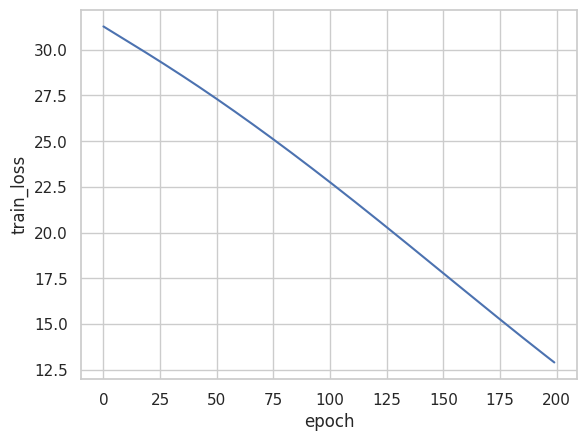

In [79]:
## Plot of Epoch train loss
sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="train_loss",
                data=train_val_loss_df)


## validation loss curve

Text(0, 0.5, 'val_loss')

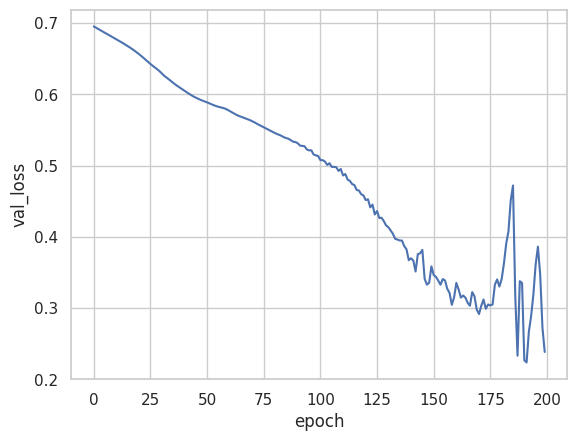

In [80]:


sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="test_loss",
                data=train_val_loss_df)
plt.ylabel('val_loss')


## Train Pearsons CC

Text(0, 0.5, 'Train Pearsons CC')

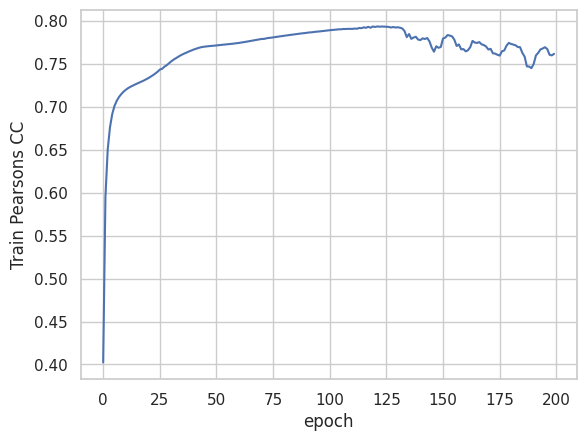

In [81]:
sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="train_corr",
                data=train_val_loss_df)
plt.ylabel('Train Pearsons CC')
#train_val_loss_df


## Validation Pearsons CC

Text(0, 0.5, 'validation Pearsons CC')

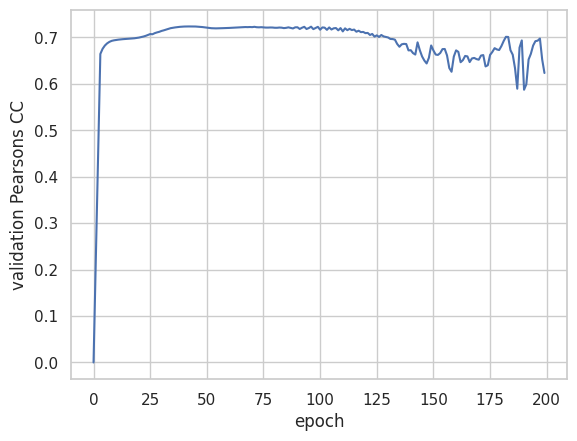

In [82]:
sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="test_corr",
                data=train_val_loss_df)
plt.ylabel('validation Pearsons CC')


## Train spearmen rank C

Text(0, 0.5, 'Train spearmen rank C')

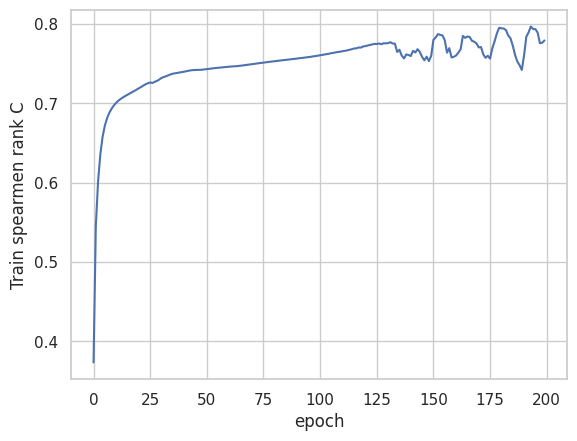

In [83]:
sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="train_scc",
                data=train_val_loss_df)
plt.ylabel('Train spearmen rank C')
#train_val_loss_df

## Validation spearmen rank C

Text(0, 0.5, 'validation spearmen rank C')

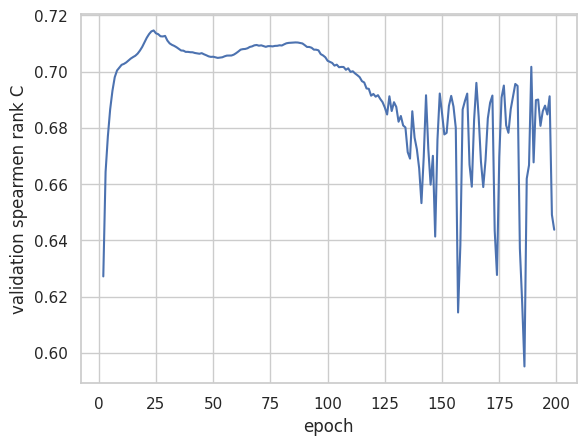

In [84]:
sns.set(style='whitegrid')
sns.lineplot(x="epoch",
                y="test_scc",
                data=train_val_loss_df)
plt.ylabel('validation spearmen rank C')
#train_val_loss_df

In [85]:
mean_train_pcc = train_val_loss_df.train_corr.mean()
print("Train mean pearson corr \t%.6f" % (mean_train_pcc))

Train mean pearson corr 	0.766562


In [86]:
mean_test_pcc = train_val_loss_df.test_corr.mean()
print("Test mean pearson corr \t%.6f" % (mean_test_pcc))


Test mean pearson corr 	0.691607


In [87]:
mean_train_scc = train_val_loss_df.train_scc.mean()

print("Test train spearmen corr \t%.6f" % (mean_train_scc))


Test train spearmen corr 	0.750342


In [88]:
mean_test_scc = train_val_loss_df.test_scc.mean()
print("Test test spearmen corr \t%.6f" % (mean_test_scc))

Test test spearmen corr 	0.692951


## RUN INFERENCE

In [89]:
cell_features = np.genfromtxt(genotype, delimiter=',')
drug_features = np.genfromtxt(fingerprint, delimiter=',')
num_cells = len(cell2id)
num_drugs = len(drug2id)
num_genes = len(gene2id)
drug_dim = len(drug_features[0,:])
#output_dir = params['output_dir']
model_trained_path = 'NOTEBOOK/model_final.pt'
predict_data = prepare_predict_data(test_data_file, cell2id, drug2id)


Total number of cell lines = 1225
Total number of drugs = 684


## INFERENCE RESULT FROM TRAINED RESULT

In [90]:
predict_dcell(predict_data, num_genes, drug_dim, model_trained_path, hidden, batch_size,
            result, cell_features, drug_features, CUDA_ID, output_dir)

Begin test evaluation
tensor(0.2102, device='cuda:0')
Test pearson corr	GO:0008150	0.623196
Test spearman corr	GO:0008150	0.643764
{'test_loss': 0.21023859083652496, 'test_pcc': 0.6231955885887146, 'test_MSE': 0.4328762337937951, 'test_r2': -4.1938350576424925, 'test_scc': 0.6437642837642839}


/tmp/ipykernel_2576912/133729123.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/133729123.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = np.

## INFERENCE RESULT FROM PRE-TRAINED MODEL FROM IDEKARLAB

In [91]:
cell_features = np.genfromtxt(genotype, delimiter=',')
drug_features = np.genfromtxt(fingerprint, delimiter=',')
num_cells = len(cell2id)
num_drugs = len(drug2id)
num_genes = len(gene2id)
drug_dim = len(drug_features[0,:])
#output_dir = params['output_dir']
model_trained_path = 'Data/drugcell_v1.pt'
predict_data = prepare_predict_data(test_data_file, cell2id, drug2id)
predict_dcell(predict_data, num_genes, drug_dim, model_trained_path, hidden, batch_size,
            result, cell_features, drug_features, CUDA_ID, output_dir)

Total number of cell lines = 1225
Total number of drugs = 684


/homes/ac.rgnanaolivu/miniconda3/envs/rohan_python/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'drugcell_NN.drugcell_nn' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ac.rgnanaolivu/miniconda3/envs/rohan_python/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/homes/ac.rgnanaolivu/miniconda3/envs/rohan_python/lib/python3.9/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.Batc

Begin test evaluation
tensor(0.0141, device='cuda:0')
Test pearson corr	GO:0008150	0.822806
Test spearman corr	GO:0008150	0.789810
{'test_loss': 0.014052328653633595, 'test_pcc': 0.822806179523468, 'test_MSE': 0.08537179536558688, 'test_r2': 0.6528445515808476, 'test_scc': 0.7898097338097337}


/tmp/ipykernel_2576912/133729123.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = np.array([p.cpu() for preds in test_predict for p in preds] ,dtype = np.float )
/tmp/ipykernel_2576912/133729123.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.array([l.cpu() for label in labels for l in label],dtype = np.

## combine result data

In [92]:
test_df = pd.read_csv(test_data_file, sep='\t', header=None)
columns = ['CELL_LINE', "DRUG", "RESPONSE"]
test_df.columns = columns

trained_model_results_df = pd.read_csv("NOTEBOOK/MODEL/Result/trained_model_drugcell.predict", header=None)
trained_model_results_df.columns = ['TRAINED_MODEL_RESPONSE']
pre_built_model_results_df = pd.read_csv("NOTEBOOK/MODEL/Result/prebuilt_model_drugcell.predict", header=None)
pre_built_model_results_df.columns = ['PREBUILT_MODEL_RESPONSE']
#pre_built_model_results_df
test_df['TRAINED_MODEL_RESPONSE'] = trained_model_results_df['TRAINED_MODEL_RESPONSE']
test_df['PREBUILT_MODEL_RESPONSE'] =pre_built_model_results_df['PREBUILT_MODEL_RESPONSE']
test_df.to_csv("NOTEBOOK/MODEL/Result/DrugCell_test_data.prediction.csv", index=False)